In [1]:
#Import Libraries
import io
import math 
import os
import pathlib
from glob import glob

import earthpy as et
import earthpy.appeears as etapp
import earthpy.earthexplorer as etee
import geopandas as gpd
import hvplot.xarray  
import hvplot.pandas
import matplotlib.pyplot as plt
import pandas as pd
import rioxarray as rxr
import rioxarray.merge as rxrmerge
import requests
import xarray as xr
import zipfile
from shapely.geometry import box
from xrspatial import slope

In [2]:
# Create data directory
data_dir = os.path.join(et.io.HOME, et.io.DATA_NAME, 'final')

if not os.path.exists(data_dir):
        os.makedirs(data_dir)

# Make data directory the working directory
os.chdir(data_dir)

# Check working directory
print(os.getcwd())

# # Create directory for soil datafiles
# soil_path=os.path.join(data_dir, 'soil')
# if not os.path.exists(soil_path):
#         os.makedirs(soil_path)

# Define utm zone
utm = 32613

/home/jovyan/earth-analytics/data/final


In [3]:
# Code adapted from: https://medium.com/@loldja/reading-shapefile-zips-from-a-url-in-python-3-93ea8d727856
# Create directory
grassland_url = ('https://data.fs.usda.gov/geodata/edw/'
                 'edw_resources/shp/S_USA.NationalGrassland.zip'
)
print('Downloading shapefile...')

# Request data from url
grassland_request = requests.get(grassland_url)
grassland_zip = zipfile.ZipFile(io.BytesIO(grassland_request.content))
print("Done")

# Extract files from Zip to 
grassland_zip.extractall(
    path=os.path.join(data_dir, 'national-grassland')
    )

Done


In [4]:
# Import shapefile
grassland_gdf = gpd.read_file(os.path.join(
    data_dir, 'national-grassland', 'S_USA.NationalGrassland.shp')
    )

select_grassland_gdf = (
    grassland_gdf
    .set_index('GRASSLANDN')
    .loc[['Comanche National Grassland', 'Pawnee National Grassland']]
)

select_grassland_gdf

,NATIONALGR,GIS_ACRES,SHAPE_AREA,SHAPE_LEN,geometry
GRASSLANDN,,,,,
Comanche National Grassland,295522010328,444413.904,0.183064,26.658022,"MULTIPOLYGON (((-104.02263 37.69224, -104.0225..."
Pawnee National Grassland,295523010328,208424.885,0.089972,15.341594,"MULTIPOLYGON (((-104.58106 40.82664, -104.5810..."


In [5]:
def get_polaris_data(data_directory, input_gdf, index_col_name):
    """
    This function downloads in Polaris soil data for the extent of each 
    row in a geodataframe and creates a merged data array. Downloaded 
    data is saved in individual folders for each row. Merged data arrays
    for each row are saved in "Merged_files" subfolder.

    Attributes
    ----------
    data_directory : path
        The path to the data directory. A sub-directory will be created
        within this directory for the soil data downloads. 

    input_gdf: geopandas.GeoDataFrame
        A geodataframe that contains the areas of interest. Polaris soil
        data will be downloaded according to the bounds of each row in 
        the dataframe. 
    
    index_col_name: string
        A string containing the name of the geoDataFrame column that
        should be used as the index. This index will be used to name
        output files.
    
    Returns
    ----------
    output_lst: list of data arrays
        Returns a list of data arrays representing the merged Polaris
        tif data for each row in the input geodataframe
    """

    # Set index to specified index column
    input_gdf = input_gdf.reset_index().set_index(index_col_name)

    # Create dataframe of bounds of each gdf row
    bound_pd = pd.concat([input_gdf.bounds], axis=1)

    file_list = []
    
    # Loop through each row in the boundary dataframe
    for ind in bound_pd.index:
        print("\n", ind, ":")
        # Define and round min and max longitude and latitudes
        min_lon = math.floor(bound_pd['minx'][ind])
        max_lon = math.ceil(bound_pd['maxx'][ind])
        min_lat = math.floor(bound_pd['miny'][ind])
        max_lat = math.ceil(bound_pd['maxy'][ind])
        # Define range
        lat_range = range(min_lat,max_lat)
        lon_range = range(min_lon,max_lon)

        # Create template for polaris url path
        polaris_template_url = 'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/' \
                    '{0}/{1}/{2}/lat{3}{4}_lon{5}{6}.tif'
        # Create template for file names
        polaris_template_name = 'mean_ph_lat{0}{1}_lon{2}{3}.tif'

        # Create sub-directory for soil data
        soil_dir = os.path.join(data_directory, "soil_data")
        if not os.path.exists(soil_dir):
            os.makedirs(soil_dir)

        # Create sub-folders for each row's data
        soil_row_dir = os.path.join(soil_dir, str(ind).replace(" ", "_"))
        if not os.path.exists(soil_row_dir):
            os.makedirs(soil_row_dir)
        
        # Create sub-folder for merged data arrays
        soil_merged_dir = os.path.join(soil_dir, "Merged_tifs")
        if not os.path.exists(soil_merged_dir):
            os.makedirs(soil_merged_dir)
        
        # For each latitude and longitude in the extent, download file
        for lat in lat_range:
            for lon in lon_range:
                # Define url for each data file in extent
                url = polaris_template_url.format('ph',
                                        'mean',
                                        '60_100',
                                        str(lat),
                                        str(lat+1),
                                        str(lon),
                                        str(lon+1))
                # Define file name for each data file in extent
                file_name = polaris_template_name.format(str(lat),
                                        str(lat+1),
                                        str(lon),
                                        str(lon+1))
                # Check if tif file is in directory. Download if not.
                file_name_path = os.path.join(soil_row_dir, file_name)
                if not os.path.exists(file_name_path): 
                    print(file_name, "does not exist. Downloading file")
                    r = requests.get(url, allow_redirects=True)
                    open(file_name_path, 'wb').write(r.content)
                else:
                    print(file_name, "is already downloaded")

        # Merge arrays if the merged file does not exist
        merge_template_name = '{0}_merged_da.tif'
        merge_da_name = merge_template_name.format(str(ind).replace(" ", "_"), ".tif")
        if not os.path.exists(os.path.join(soil_merged_dir, merge_da_name)): 
            print("Soil data is being merged.")
            tif_paths = glob(os.path.join(soil_row_dir, '*.tif'))
            das = [rxr.open_rasterio(tif, masked=True) for tif in tif_paths]
            merged_da = rxrmerge.merge_arrays(das)
            merged_da.rio.to_raster(
                os.path.join(soil_merged_dir, merge_da_name)
                )
        else:
            print("A merged soil data array already exists.")
            merged_da = rxr.open_rasterio(
                os.path.join(soil_merged_dir, merge_da_name), masked=True
                )
        
        # Add file to list of tif files to return
        file_list.append(os.path.join(soil_merged_dir, merge_da_name))
        
    # Return files
    output_lst = [rxr.open_rasterio(tif, masked=True).squeeze() for tif in file_list]
    return output_lst

comanche_pH_da, pawnee_pH_da = get_polaris_data(data_dir, select_grassland_gdf, "GRASSLANDN")

comanche_pH_da



 Comanche National Grassland :
mean_ph_lat3637_lon-105-104.tif is already downloaded
mean_ph_lat3637_lon-104-103.tif is already downloaded
mean_ph_lat3637_lon-103-102.tif is already downloaded
mean_ph_lat3738_lon-105-104.tif is already downloaded
mean_ph_lat3738_lon-104-103.tif is already downloaded
mean_ph_lat3738_lon-103-102.tif is already downloaded
A merged soil data array already exists.

 Pawnee National Grassland :
mean_ph_lat4041_lon-105-104.tif is already downloaded
mean_ph_lat4041_lon-104-103.tif is already downloaded
mean_ph_lat4142_lon-105-104.tif is already downloaded
mean_ph_lat4142_lon-104-103.tif is already downloaded
A merged soil data array already exists.


<xarray.DataArray (y: 7200, x: 10800)>
[77760000 values with dtype=float32]
Coordinates:
    band         int64 1
  * x            (x) float64 -105.0 -105.0 -105.0 ... -102.0 -102.0 -102.0
  * y            (y) float64 38.0 38.0 38.0 38.0 38.0 ... 36.0 36.0 36.0 36.0
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [6]:
# Clip files to bounds

select_grassland_utm_gdf = select_grassland_gdf.to_crs(utm)

pawnee_pH_da = (pawnee_pH_da
                  .rio.reproject(utm)
                  .rio.clip_box(*select_grassland_utm_gdf
                                .bounds
                                .loc['Pawnee National Grassland'])
)

comanche_pH_da = (comanche_pH_da
                  .rio.reproject(utm)
                  .rio.clip_box(*select_grassland_utm_gdf
                                .loc[['Comanche National Grassland']]
                                .total_bounds)
)

In [7]:
# comanche_pH_da.hvplot() * select_grassland_utm_gdf.loc[['Comanche National Grassland']].hvplot(color=None, line_color="white")

In [ ]:
# pawnee_pH_da.hvplot() * select_grassland_utm_gdf.loc[['Pawnee National Grassland']].hvplot(color=None, line_color="white")

# Elevation Data

In [26]:
# select_grassland_gdf

# select_grassland_gdf = select_grassland_gdf.to_crs(4326)

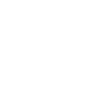

In [17]:
min_lon = 2

test = box(minx=min_lon, miny=min_lon, 
    maxx=min_lon, maxy=min_lon)

test

In [21]:
data_dir = os.path.join(data_dir, "test")

def get_srtm_data(input_gdf, index_col_name):
    # Set index
    input_gdf = input_gdf.reset_index().set_index(index_col_name)

    # Create dataframe of bounds of each gdf row
    bound_pd = pd.concat([input_gdf.bounds], axis=1)

    # Loop through each row in the boundary dataframe
    for ind in bound_pd.index:
        print("\n", ind, ":")
        # Define and round min and max longitude and latitudes
        min_lon = bound_pd['minx'][ind]
        max_lon = bound_pd['maxx'][ind]
        min_lat = bound_pd['miny'][ind]
        max_lat = bound_pd['maxy'][ind]
        bbox = box(minx=bound_pd['minx'][ind], miny=bound_pd['miny'][ind], 
            maxx=bound_pd['maxx'][ind], maxy= bound_pd['maxy'][ind])
         
        elevation_downloader = etapp.AppeearsDownloader(
            download_key="SRTM_DEM",
            ea_dir=data_dir,
            product="SRTMGL1_NC.003",
            layer="SRTMGL1_DEM",
            start_date="02-11-2000",
            end_date="02-21-2000",
            polygon=bbox
        )

        # Download files if the download directory does not exist
        if not os.path.exists(elevation_downloader.data_dir):
            elevation_downloader.download_files()

get_srtm_data(select_grassland_gdf, "GRASSLANDN")


 Comanche National Grassland :


KeyboardInterrupt: 

In [22]:
# https://lpdaac.usgs.gov/products/srtmgl1v003/
# https://appeears.earthdatacloud.nasa.gov/api/#temporary-s3-credentials
# https://appeears.earthdatacloud.nasa.gov/products
# https://lpdaac.usgs.gov/resources/e-learning/getting-started-with-the-a%CF%81%CF%81eears-api-submitting-and-downloading-an-area-request/

# Download Elevation Data Using Appeears
elevation_downloader = etapp.AppeearsDownloader(
    download_key="SRTM_DEM_test",
    ea_dir=data_dir,
    product="SRTMGL1_NC.003",
    layer="SRTMGL1_DEM",
    start_date="02-11-2020",
    end_date="02-21-2020",
    polygon=select_grassland_gdf,
)

# Download files if the download directory does not exist
if not os.path.exists(elevation_downloader.data_dir):
    elevation_downloader.download_files()

KeyboardInterrupt: 

In [28]:
def download_srtm_data(data_directory, input_gdf):
    # https://lpdaac.usgs.gov/products/srtmgl1v003/
    # https://appeears.earthdatacloud.nasa.gov/api/#temporary-s3-credentials
    # https://appeears.earthdatacloud.nasa.gov/products
    # https://lpdaac.usgs.gov/resources/e-learning/getting-started-with-the-a%CF%81%CF%81eears-api-submitting-and-downloading-an-area-request/

    data_dir = data_directory

    # Download Elevation Data Using APPEEARS
    elevation_downloader = etapp.AppeearsDownloader(
        download_key="SRTM_DEM",
        ea_dir=data_dir,
        product="SRTMGL1_NC.003",
        layer="SRTMGL1_DEM",
        start_date="02-11-2000",
        end_date="02-21-2000",
        polygon=input_gdf,
    )

    # Download files if the download directory does not exist
    if not os.path.exists(elevation_downloader.data_dir):
        elevation_downloader.download_files()

    # Define elevation path
    # elevation_tif_path = glob(os.path.join(
    #         elevation_downloader.data_dir, 
    #         "SRTMGL1_NC.003_2000001_to_2023342",
    #         "*tif")
    # )

    paths = ('/home/jovyan/earth-analytics/data/final/SRTM_DEM/SRTMGL1_NC.003_2000001_to_2023342/SRTMGL1_NC.003_SRTMGL1_DEM_doy2000042_aid0001.tif')

    elevation_da = rxr.open_rasterio(paths, masked=True).squeeze() 

    #     # Get elevation data array(s)
    # elevation_da = [rxr.open_rasterio(elevation_tif_path, masked=True).squeeze() 
    #                 for path in elevation_tif_path][0]
    # elevation_da.name = 'Elevation'
    print(paths)

    return elevation_da


elev_da = download_srtm_data(data_dir, select_grassland_gdf)


/home/jovyan/earth-analytics/data/final/SRTM_DEM/SRTMGL1_NC.003_2000001_to_2023342/SRTMGL1_NC.003_SRTMGL1_DEM_doy2000042_aid0001.tif


In [9]:
# Read elevation data.
elevation_tif_path = (
    os.path.join(data_dir, 'SRTM_DEM',
                'SRTMGL1_NC.003_2000001_to_2023342',
                'SRTMGL1_NC.003_SRTMGL1_DEM_doy2000042_aid0001.tif')
)

# elevation_da = rxr.open_rasterio(elevation_tif_path, masked=True)
# elevation_da

# New version of reading in elevation data array
elev_da = rxr.open_rasterio(elevation_tif_path, masked=True).squeeze()
elev_da.name = 'Elevation'

In [ ]:
# Clip array for Comanche

# Clip array for Pawnee


In [30]:
# def get_slope_and_aspect(input_gdf)

In [10]:
# Calculate slope for area for interest
aoi_slope_da = slope(elev_da)
aoi_slope_da

<xarray.DataArray 'slope' (y: 15394, x: 7610)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x            (x) float64 5.175e+05 5.176e+05 ... 7.39e+05 7.391e+05
  * y            (y) float64 4.542e+06 4.542e+06 ... 4.094e+06 4.094e+06
    band         int64 1
    spatial_ref  int64 0
Attributes:
    add_offset:     0.0
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    units:          Meters

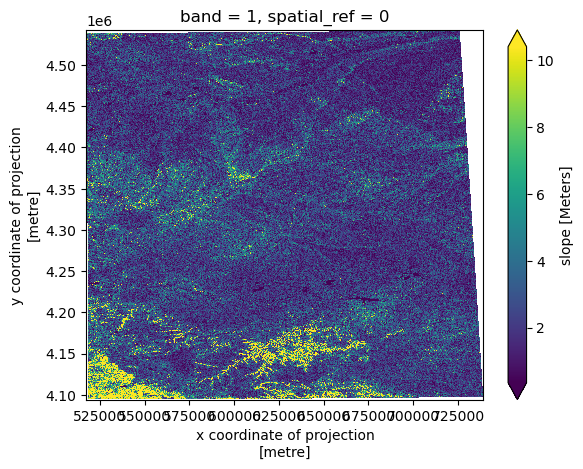

In [11]:
aoi_slope_da.plot(robust=True)

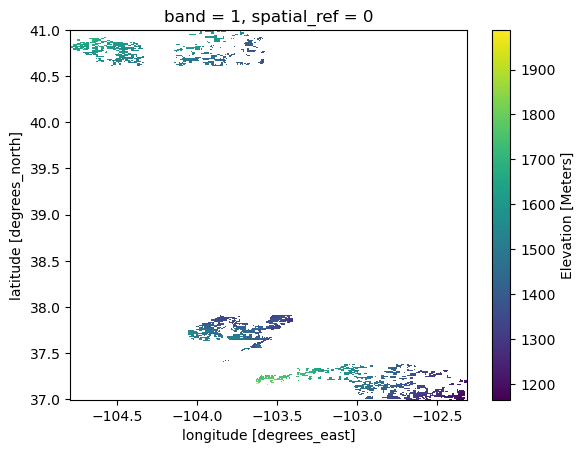

In [33]:
# Clip elevation data to selected grasslands
elev_clip_da = elev_da.rio.clip(select_grassland_gdf.geometry)
elev_clip_da.plot()

In [34]:
aoi_clip_slope_da = aoi_slope_da.rio.clip(select_grassland_gdf.to_crs("EPSG:32613").geometry)
# aoi_clip_slope_da.plot(robust=True)

# Climate Data

In [9]:
def download_maca2_data(data_directory, model, scenario, variable_abb, st_year, end_year):
    """
    Attributes
    ----------
    data_directory: path
        The path to the data directory where the MACA2 data will be 
        stored

    model: string
        Represents the selected MACA2 model that data will be downloaded 
        for. Acceptable values are: 'bcc-csm1-1', 'bcc-csm1-1-m',
        'BNU-ESM', 'CanESM2', 'CCSM4', 'CNRM-CM5', 'CSIRO-Mk3-6-0',
        'GFDL-ESM2G', 'GFDL-ESM2M', 'HadGEM2-CC365', 'HadGEM2-ES365',
        'inmcm4', 'IPSL-CM5A-MR', 'IPSL-CM5A-LR', 'IPSL-CM5B-LR','MIROC5',
        'MIROC-ESM', 'MIROC-ESM-CHEM','MRI-CGCM3', 'NorESM1-M'.

    scenario: string
        Represents the climate scenario that data will be downloaded for.
        Must be 'rcp45', 'rcp85', or 'historical'.

    variable_abb: string
        The abbreviation for the climate variable that data will be 
        downloaded for. Acceptable values are: tasmax', 'tasmin', 
        'rhsmax', 'rhsmin', 'pr', 'rsds', 'uas', 'vas', 'huss'.

    st_year: integer
        A four-digit integer representing the start year for the data 
        download. Must be between 2006 and 2099 for rcp45 and rcp85, or 
        between 1950 and 2005 for historical scenarios.

    end_year: integer
        A four-digit integer representing the end year for the data 
        download. Must be between 2006 and 2099 for rcp45 and rcp85, or 
        between 1950 and 2005 for historical scenarios.
    
    Returns
    ----------
    clim_da: xarray.Dataset
        Returns a dataset containing the downloaded MACA2 data

    """
    model_lst = ['bcc-csm1-1', 'bcc-csm1-1-m',
        'BNU-ESM', 'CanESM2', 'CCSM4', 'CNRM-CM5', 'CSIRO-Mk3-6-0',
        'GFDL-ESM2G', 'GFDL-ESM2M', 'HadGEM2-CC365', 'HadGEM2-ES365',
        'inmcm4', 'IPSL-CM5A-MR', 'IPSL-CM5A-LR', 'IPSL-CM5B-LR','MIROC5',
        'MIROC-ESM', 'MIROC-ESM-CHEM','MRI-CGCM3', 'NorESM1-M']
    
    if model not in model_lst:
        raise ValueError("The listed model {0} is not valid."
                         "Check input".format(model)
                         )

    variables_long_list = ['precipitation', 'air_temperature', 
                      'air_temperature', 'relative_humidity',
                      'relative_humidity', 
                      'surface_downwelling_shortwave_flux_in_air',
                      'eastward_wind', 
                      'northward_wind',
                      'specific_humidity'
    ]

    variables_abb_lst = ['pr', 'tasmax', 'tasmin', 'rhsmin', 'rhsmax', 
                      'rsds', 'uas', 'vas', 'huss']
    
    if variable_abb not in variables_abb_lst:
        raise ValueError("The listed variable abbreviation {0} is not "
                        "valid. Check value".format(variable_abb)
                         )

    # Dictionary to get variable long name
    variables_dict = {variables_abb_lst[i]: variables_long_list[i] 
           for i in range(len(variables_long_list))}

    # Create template for MACA url path
    template_url = ("http://thredds.northwestknowledge.net:8080"\
                "/thredds/ncss/agg_macav2metdata_{0}_{1}_r"\
                "{2}i1p1_{3}_{4}_CONUS_monthly.nc"\
                "?var={5}"\
                "&disableLLSubset=on"
                "&disableProjSubset=on"
                "&horizStride=1&time_start={6}-01-15T00%3A00%3A00Z"
                "&time_end={7}-12-15T00%3A00%3A00Z"
                "&timeStride=1"
                "&accept=netcdf"
    )

    # Define whether url value is r6i1p1 or r1i1p1
    if model == "CCSM4":
        value = 6
    else:
        value = 1
    
    # Define year range for scenario
    if scenario == "historical":
        year_range = "1950_2005"
    else:
        year_range = "2006_2099"
    
    # Create url for download
    url = template_url.format(variable_abb,
                              model,
                              value,
                              scenario,
                              year_range,
                              variables_dict.get(variable_abb),
                              st_year,
                              end_year
                              )

    # Make request to url
    maca_response = requests.get(url)

    # Create template for MACA2 file name
    template_filename = ("{0}_{1}_{2}_{3}to{4}.nc"
    )

    # Generate file name for saving
    file_path = os.path.join(data_directory, template_filename.format(model,
                                        scenario,
                                        variable_abb,
                                        st_year,
                                        end_year
                                        )
    )
    
    if not os.path.exists(file_path):
        # Save data
        with open(file_path, 'wb') as maca_file:
            maca_file.write(maca_response.content)
        print("Downloading data")
    
    else:
        print("A MACA2 file for this scenario is already saved in the "
              "directory. Skipping download.")

    # Open the dataset    
    clim_dataset = xr.open_dataset(file_path)

    return clim_dataset

CCSM4_rcp45_da = download_maca2_data(data_dir, "CCSM4", "rcp45", "pr", 2040, 2040)
    
CCSM4_rcp85_da = download_maca2_data(data_dir, "CCSM4", "rcp85", "pr", 2040, 2040)

A MACA2 file for this scenario is already saved in the directory. Skipping download.
A MACA2 file for this scenario is already saved in the directory. Skipping download.


In [10]:
# Assign coords & set spatial dimensions
def maca2_assign_coords(data_array, gdf):
    # Assign coordinates
    data_array = data_array.assign_coords(lon =  data_array.lon - 360, inplace=True)
    # Get data variable name
    var_name = list(data_array.keys())[0]
    # Select data
    out_da = data_array[var_name]
    out_da.rio.write_crs("epsg:4326", inplace=True)
    out_da.rio.set_spatial_dims('lon','lat',inplace=True)
    return out_da

CCSM4_rcp45_da = maca2_assign_coords(CCSM4_rcp45_da, select_grassland_gdf)
CCSM4_rcp85_da = maca2_assign_coords(CCSM4_rcp85_da, select_grassland_gdf)

In [11]:
# Clip to area of interest.
def clip_da_to_area(data_array, input_gdf):
    bound_pd = pd.concat([input_gdf.bounds], axis=1)  
    array_lst = []  
    # Loop through each row in the boundary dataframe
    for ind in bound_pd.index:
        print("\n", ind, ":")
        # Clip to area of interest.
        data_array_clip = data_array.rio.clip_box(
            minx=bound_pd['minx'][ind],
            miny=bound_pd['miny'][ind],
            maxx=bound_pd['maxx'][ind],
            maxy=bound_pd['maxy'][ind]
            )
        array_lst.append(data_array_clip)
        print("Array clipped")
    return array_lst
    
Comanche_CCSM4_rcp45_da, Pawnee_CCSM4_rcp45_da = clip_da_to_area(CCSM4_rcp85_da, select_grassland_gdf)
Comanche_CCSM4_rcp85_da, Pawnee_CCSM4_rcp85_da = clip_da_to_area(CCSM4_rcp85_da, select_grassland_gdf)


 Comanche National Grassland :
Array clipped

 Pawnee National Grassland :
Array clipped

 Comanche National Grassland :
Array clipped

 Pawnee National Grassland :
Array clipped


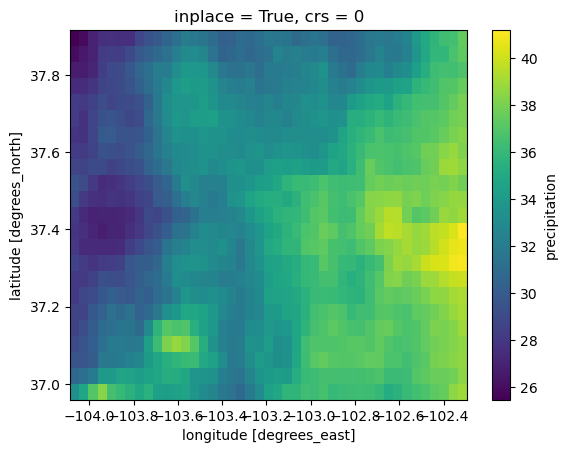

In [12]:
Comanche_CCSM4_rcp85_da.mean("time").plot.imshow(x='lon', y='lat')

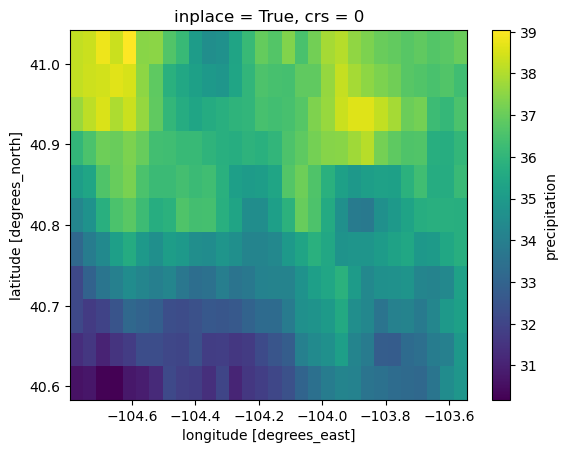

In [130]:
Pawnee_CCSM4_rcp85_da.mean("time").plot.imshow(x='lon', y='lat')

# Check if arrays match

In [131]:
comanche_pH_da.rio.crs

CRS.from_epsg(4326)

In [133]:
CCSM4_rcp45_da.rio.crs

CRS.from_epsg(4326)

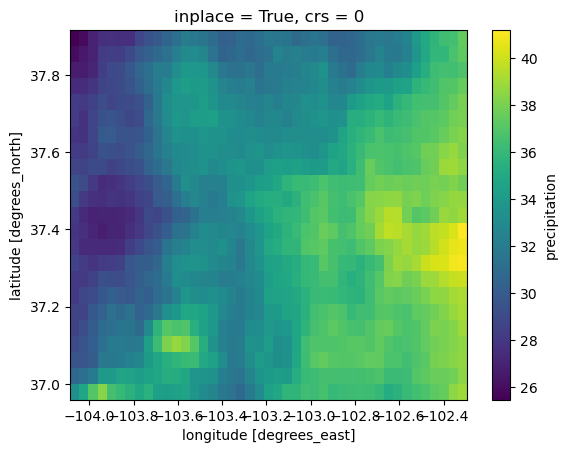

In [141]:
Comanche_CCSM4_rcp85_da.mean("time").plot.imshow(x='lon', y='lat')

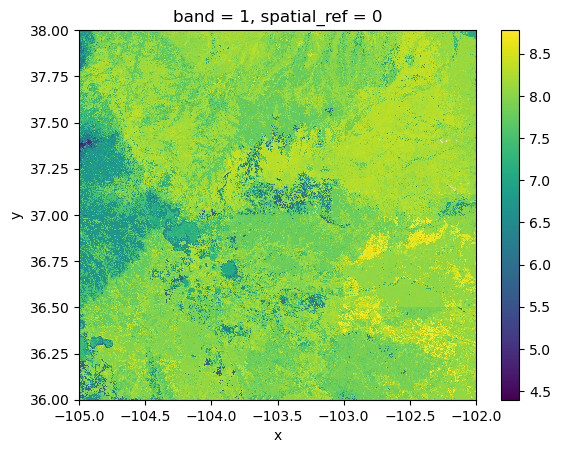

In [158]:
comanche_pH_da.plot()

In [142]:
comanche_pH_da.rio.reproject_match(Comanche_CCSM4_rcp85_da)

<xarray.DataArray (band: 1, y: 23, x: 43)>
array([[[7.75161  , 6.191383 , 8.043658 , 7.4396   , 7.955142 ,
         7.935969 , 7.718203 , 7.9811883, 7.7751083, 7.7751083,
         7.776724 , 7.7751083, 7.7751083, 7.7751083, 7.802843 ,
         7.7751083, 7.761761 , 7.7751083, 8.08905  , 7.991708 ,
         7.7703323, 8.066407 , 7.0674276, 7.7751083, 8.08905  ,
         8.08905  , 7.7773094, 7.777664 , 7.5247383, 8.000539 ,
         7.777262 , 7.8315754, 7.8693943, 8.387235 , 8.427054 ,
         7.7891636, 7.866638 , 8.1216955, 8.05627  , 8.05627  ,
         8.063959 , 8.078461 , 8.074687 ],
        [5.71     , 8.200115 , 8.099386 , 8.407738 , 7.376232 ,
         8.304867 , 7.9300747, 7.993559 , 7.4930735, 7.1811905,
         7.539219 , 7.712997 , 8.086891 , 7.625738 , 8.024209 ,
         7.808121 , 6.2583127, 7.760324 , 7.73921  , 7.7837243,
         8.52861  , 7.799122 , 8.107237 , 5.9693055, 7.7751083,
         7.9715843, 7.900446 , 7.774889 , 7.783317 , 7.9110613,
         8.085828 , 7.783497 , 8.097158 , 8.320051 , 8.054789 ,
         8.063173 , 8.049531 , 8.337171 , 8.318254 , 8.213727 ,
         8.0354   , 7.9389052, 8.156625 ],
        [8.078098 , 7.7751083, 8.073009 , 8.179867 , 7.3043966,
         8.44116  , 8.057036 , 8.521878 , 7.74477  , 7.95843  ,
...
         7.7751083, 8.363356 , 8.323033 , 7.7751083, 8.332315 ,
         8.063135 , 8.267042 , 8.398395 ],
        [8.146699 , 8.034479 , 8.222452 , 8.201374 , 8.039707 ,
         8.1613865, 8.0243   , 8.162344 , 8.053173 , 8.330023 ,
         8.164772 , 8.014861 , 8.181614 , 7.7751083, 7.7751083,
         8.070347 , 7.8820977, 7.8134465, 7.7486444, 8.014766 ,
         8.052587 , 8.011708 , 7.7845244, 7.7135158, 8.110544 ,
         8.304489 , 7.891342 , 7.801922 , 7.7751083, 7.9301405,
         7.8922653, 8.068578 , 8.051377 , 8.063853 , 8.063853 ,
         7.5880938, 8.063853 , 6.8569455, 7.3830533, 8.351907 ,
         8.359294 , 8.353718 , 8.062391 ],
        [8.059635 , 8.277196 , 8.01     , 8.079563 , 8.14139  ,
         8.243469 , 8.131015 , 8.07752  , 8.310282 , 8.306395 ,
         8.025094 , 8.14607  , 8.0306835, 8.005953 , 7.5663996,
         7.739565 , 7.949957 , 8.365421 , 7.7751083, 7.7751083,
         8.052538 , 8.288158 , 7.45872  , 7.8631415, 8.10326  ,
         8.190756 , 7.6374135, 8.063995 , 7.844814 , 7.5834465,
         8.214394 , 7.9680586, 8.126168 , 7.829138 , 7.9952803,
         7.7692194, 8.282137 , 8.325851 , 8.063853 , 8.062429 ,
         8.434117 , 8.063853 , 8.376652 ]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
    spatial_ref  int64 0
  * x            (x) float64 -104.1 -104.0 -104.0 ... -102.4 -102.4 -102.3
  * y            (y) float64 36.98 37.02 37.06 37.1 ... 37.77 37.81 37.85 37.9
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [135]:
CCSM4_2050_rcp45_pr_clip_da.rio.reproject_match(elev_clip_da)
aoi_clip_slope_da.rio.reproject_match(elev_clip_da)
merged_soil_da.rio.reproject_match(elev_clip_da)

NameError: name 'CCSM4_2050_rcp45_pr_clip_da' is not defined

# Train - Soil pH

In [43]:
# Ideal soil ph of 4.8 to 8.0 (https://www.nrcs.usda.gov/plantmaterials/etpmcpg13196.pdf); mean of this range is 6.4
diff_soil_da = abs(6.4 - merged_soil_da)
test = (diff_soil_da - diff_soil_da.min()) / (diff_soil_da.max()-diff_soil_da.min())
test

<xarray.DataArray (band: 1, y: 21600, x: 10800)>
array([[[0.58679736, 0.5907079 , 0.588402  , ..., 0.06955472,
         0.06955472, 0.06955472],
        [0.5965586 , 0.58679736, 0.5913004 , ..., 0.07689695,
         0.07689695, 0.16528128],
        [0.57776433, 0.586669  , 0.586669  , ..., 0.18170473,
         0.0382776 , 0.0549452 ],
        ...,
        [0.47850874, 0.47520852, 0.47520852, ..., 0.55866075,
         0.5618675 , 0.5650657 ],
        [0.42701635, 0.42701635, 0.4604683 , ..., 0.55928624,
         0.55881315, 0.56118464],
        [0.45760044, 0.4813533 , 0.52784914, ..., 0.5586836 ,
         0.56031865, 0.56031865]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -105.0 -105.0 -105.0 ... -102.0 -102.0 -102.0
  * y            (y) float64 42.0 42.0 42.0 42.0 42.0 ... 36.0 36.0 36.0 36.0
    spatial_ref  int64 0

In [44]:
soil_cutpt = (1.6 - diff_soil_da.min()) / (diff_soil_da.max() - diff_soil_da.min())

soil_cutpt

<xarray.DataArray ()>
array(0.53162214)
Coordinates:
    spatial_ref  int64 0

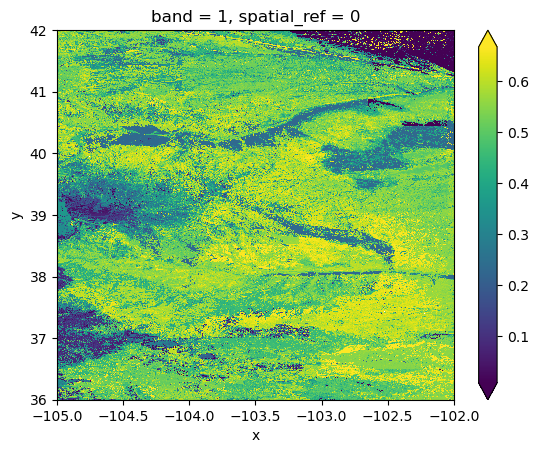

In [45]:
test.plot(robust=True)

In [46]:
# Ideal soil ph of 4.8 to 8.0 (https://www.nrcs.usda.gov/plantmaterials/etpmcpg13196.pdf); mean of this range is 6.4
diff_soil_da = abs(6.4 - elev_clip_da)
test = (diff_soil_da - diff_soil_da.min()) / (diff_soil_da.max()-diff_soil_da.min())
soil_cutpt = (1.6 - diff_soil_da.min()) / (diff_soil_da.max() - diff_soil_da.min())

soil_cutpt

<xarray.DataArray 'Elevation' ()>
array(-1.40583229)
Coordinates:
    band         int64 1
    spatial_ref  int64 0

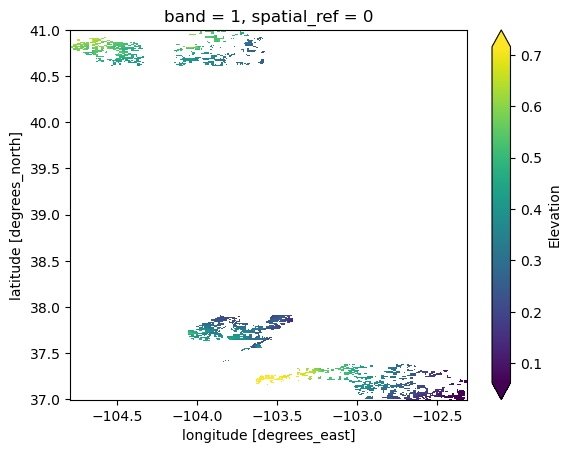

In [47]:
test.plot(robust=True)

In [48]:
from simpful import *

  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.11.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)



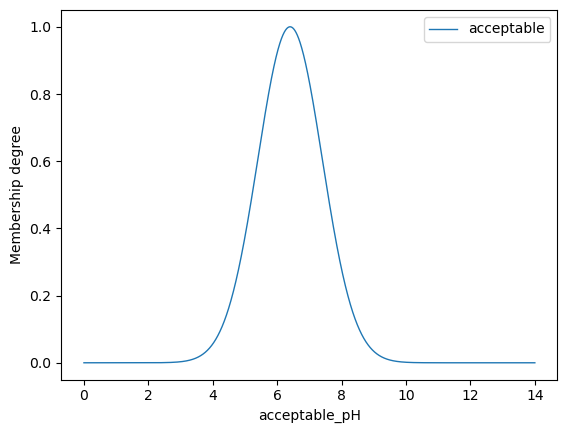

 * Detected Sugeno model type
{'Growth': 1.0}


In [89]:
# A simple decision support model to diagnose sepsis in the ICU # Create a fuzzy system object
FS = FuzzySystem()
# Define fuzzy sets for the variable PaO2
# P1 = FuzzySet(function=Triangular_MF(a=0, b=0, c=6.4), term="too_low")
# P2 = FuzzySet(function=Triangular_MF(a=4.8, b=6.4, c=8), term="ok")
# P3 = FuzzySet(function=Triangular_MF(a=6.4, b=14, c=14), term="too_high")
# LV1 = LinguisticVariable([P1,P2, P3], concept="pH", universe_of_discourse=[0,14]) 
# FS.add_linguistic_variable("pH", LV1)
# LV1.plot()

# P1 = FuzzySet(function=Sigmoid_MF(c=6.4, a=0.1), term="low")
# P2 = FuzzySet(function=InvSigmoid_MF(c=6.4, a=0.1), term="high")
# LV1 = LinguisticVariable([P1,P2], concept="pH", universe_of_discourse=[0,14]) 
# FS.add_linguistic_variable("pH", LV1)
# LV1.plot()"

# P1 = FuzzySet(function=Sigmoid_MF(c=6.4, a=1.5), term="low")
# P2 = FuzzySet(function=InvSigmoid_MF(c=6.4, a=1.5), term="high")
# LV1 = LinguisticVariable([P1,P2], concept="pH", universe_of_discourse=[0,14]) 
# FS.add_linguistic_variable("pH", LV1)
# LV1.plot()


# # Define fuzzy sets for the variable base excess
B1 = FuzzySet(function=Gaussian_MF(mu=6.4,sigma=1), term="acceptable")
LV2 = LinguisticVariable([B1], concept="acceptable_pH", universe_of_discourse=[0,14]) 
FS.add_linguistic_variable("pH", LV2)
LV2.plot()


# Define the consequents
FS.set_crisp_output_value("low_probability", 0) 
FS.set_crisp_output_value("high_probability", 1)
# Define the fuzzy rules
RULE1 = "IF (pH IS acceptable) THEN (Growth IS high_probability)"

FS.add_rules([RULE1])
FS.set_variable("pH", 9) 
print(FS.Sugeno_inference(["Growth"]))


# Define fuzzy sets for the variable Precipitation
# R1 = FuzzySet(function=Triangular_MF(a=0, b=0, c=11), term="too_low")
# R2 = FuzzySet(function=Triangular_MF(a=11, b=28, c=45), term="ok")
# R3 = FuzzySet(function=Triangular_MF(a=45, b=100, c=100), term="too_high")
# LV2 = LinguisticVariable([R1,R2, R3], concept="precip", universe_of_discourse=[0,100]) 
# FS.add_linguistic_variable("precip", LV2)
# LV2.plot()

# # Define output fuzzy sets and linguistic variable
# T_1 = FuzzySet(function=Triangular_MF(a=0, b=0, c=10), term=”small”)
# T_2 = FuzzySet(function=Triangular_MF(a=0, b=10, c=20), term=”average”)
# T_3 = FuzzySet(function=Trapezoidal_MF(a=10, b=20, c=25, d=25), term=”generous”) FS.add_linguistic_variable(”Tip”, LinguisticVariable([T_1, T_2, T_3], universe_of_discourse=[0,25]))

# Define the consequents
# FS.set_crisp_output_value("low_probability", 0) 
# FS.set_crisp_output_value("high_probability", 99)
# Define the fuzzy rules
# RULE1 = "IF (pH IS ok) AND (precip IS ok) THEN (Growth IS high_probability)"
# RULE2 = "IF (pH IS too_low) OR (pH IS too_low) OR (precip IS too_low) OR (precip IS too_high) THEN (Growth IS low_probability)"

# Add fuzzy rules to the fuzzy reasoner object 
# FS.add_rules([RULE1, RULE2])
# Set antecedent values
# FS.set_variable("pH", 7.4) 
# FS.set_variable("precip", 30) 

# Perform Sugeno inference and print output 
# print(FS.Sugeno_inference(["Growth"]))

### Data Citations
NASA JPL (2013). NASA Shuttle Radar Topography Mission Global 1 arc second [Data set]. NASA EOSDIS Land Processes Distributed Active Archive Center. Accessed 2023-12-05 from https://doi.org/10.5067/MEaSUREs/SRTM/SRTMGL1.003

Hegewisch, K.C. and Abatzoglou, J.T.. 'Data Download' web tool. Climate Toolbox (https://climatetoolbox.org/), version 2022-04-24.

In [ ]:
bounds = (select_grassland_gdf.total_bounds)

# Define extent and round to whole numbers for defining soil path file names
min_lon = math.floor(bounds[0])
max_lon = math.ceil(bounds[2])
min_lat = math.floor(bounds[1])
max_lat = math.ceil(bounds[3])

min_lon, max_lon,  min_lat, max_lat
# # https://stackoverflow.com/questions/68198525/geopandas-obtain-min-max-lat-and-long-for-all-geometries

# # Get boundaries
# select_grassland_bnd_gdf = select_grassland_gdf.bounds

# # Define extent and round to whole 
# min_lon = math.floor(float(select_grassland_bnd_gdf.minx.min()))
# max_lon = math.ceil(float(select_grassland_bnd_gdf.maxx.max()))
# min_lat = math.floor(float(select_grassland_bnd_gdf.miny.min()))
# max_lat = math.ceil(float(select_grassland_bnd_gdf.maxy.max()))

# min_lon, max_lon, max_lat, min_lat

In [ ]:
###########
# Old Polaris Download
###########
# Download Polaris tif files
# Code adapted from: 
        # https://www.tutorialspoint.com/downloading-files-from-web-using-python
        # https://github.com/njadid/Polaris_Processor/blob/master/download_polaris.py

# # # Set working directory to soil directory

# url_path_lst = []
def downloadPolaris(data_directory, geo_extent):
    """
    This function reads in Polaris soil data for a given extent into
    a specified data directory.

    Attributes
    ----------
    data_directory : path
        The path to the directory where the polaris data files are 
        to be stored.
    
    geo_extent: dictionary
        A dictionary specifying the min and maximum latitudes and 
        longitudes for the geographical extent to examine
    """
    
    bounds = (input_gdf.total_bounds)

      template_url = 'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/' \
                   '{0}/{1}/{2}/lat{3}{4}_lon{5}{6}.tif'
      template_name = 'mean_ph_lat{0}{1}_lon{2}{3}.tif'
      lat_range = range(geo_extent['lat'][0],geo_extent['lat'][1])
      lon_range = range(geo_extent['lon'][0],geo_extent['lon'][1])
      for lat in lat_range:
        for lon in lon_range:
            url = template_url.format('ph',
                                      'mean',
                                      '60_100',
                                      str(lat),
                                      str(lat+1),
                                      str(lon),
                                      str(lon+1))
            file_name = template_name.format(str(lat),
                                      str(lat+1),
                                      str(lon),
                                      str(lon+1))
            # url_path_lst.append(url)
            soil_dir = os.path.join(data_directory, "soil_data")
            file_name_path = os.path.join(soil_dir, file_name)
            if not os.path.exists(soil_dir):
                os.makedirs(soil_dir)
            if not os.path.exists(file_name_path): 
                print(file_name, "does not exist. Downloading file")
                r = requests.get(url, allow_redirects=True)
                open(file_name_path, 'wb').write(r.content)
            else:
                print(file_name, "is already downloaded")

# Define geographical extent
domain_extent = {}
domain_extent['lon'] = [min_lon, max_lon]
domain_extent['lat'] = [min_lat, max_lat]

downloadPolaris(data_dir, domain_extent)

# # Reset working directory
# os.chdir(data_dir)

In [ ]:
# https://www.geeksforgeeks.org/python-list-files-in-a-directory/
# Adapted from Multispectral Analysis assignment
def merge_soil_tif(soil_data_directory):
    # Merge soil tif data
    tif_paths = glob(os.path.join(data_dir, "soil_data", '*.tif'))
    das = [rxr.open_rasterio(tif, masked=True) for tif in tif_paths]
    merged_soil_da = rxrmerge.merge_arrays(das)
    # Save merged file to data directory
    merged_soil_da.rio.to_raster(os.path.join(data_dir, "merged_soil_da.tif"))

    test = rxr.open_rasterio(os.path.join(data_dir, "merged_soil_da.tif"), masked=True)

In [ ]:
# # Climate data
# clim_rcp45_url = (
#     "http://thredds.northwestknowledge.net:8080/thredds/catalog/"
#     "NWCSC_INTEGRATED_SCENARIOS_ALL_CLIMATE/macav2livneh/GFDL-ESM2M/"
#     "catalog.html?dataset=NWCSC_IS_ALL_SCAN/macav2livneh/GFDL-ESM2M/"
#     "macav2livneh_pr_GFDL-ESM2M_r1i1p1_rcp45_2026_2045_CONUS_monthly.nc"
# )

# r = requests.get(clim_rcp45_url, allow_redirects=True)
# open("clim_rcp45_2026_2045.nc", 'wb').write(r.content)


In [42]:
# Open the data from the thredds server
clim_rcp85_url = ("http://thredds.northwestknowledge.net:8080/thredds/"
                  "dodsC/agg_macav2metdata_pr_CCSM4_r6i1p1_rcp45"
                  "_2006_2099_CONUS_monthly.nc"
                 )
# ccsm_rcp45 = xr.open_dataset(ccsm_rcp45_url)
clim_rcp85 = xr.open_dataset(clim_rcp85_url)

# clim_rcp45_url = ("http://thredds.northwestknowledge.net:8080/thredds/dodsC/agg_macav2metdata_tasmax_CCSM4_r6i1p1_rcp45_2006_2099_CONUS_monthly.nc")

# ccsm_rcp45_url = ("http://thredds.northwestknowledge.net:8080/thredds/"
#                   "dsC/agg_macav2metdata_pr_CCSM4_r6i1p1_rcp4"
#                   "006_2099_CONUS_monthly.nc"
# )

# ccsm_rcp85_url = ("http://thredds.northwestknowledge.net:8080/thredds/"
#                   "dsC/agg_macav2metdata_pr_CCSM4_r6i1p1_rcp85"
#                   "006_2099_CONUS_monthly.nc"
# )

# ccsm_rcp45_url = ("http://thredds.northwestknowledge.net:8080/thredds/"
#                   "dsC/agg_macav2metdata_pr_CCSM4_r6i1p1_rcp4
#                   "006_2099_CONUS_monthly.nc"
# )

# ccsm_rcp85_url = ("http://thredds.northwestknowledge.net:8080/thredds/"
#                   "dsC/agg_macav2metdata_pr_CCSM4_r6i1p1_rcp85"
#                   "006_2099_CONUS_monthly.nc"
# )

# ccsm_rcp45 = xr.open_dataset(ccsm_rcp45_url)
ccsm_rcp85 = xr.open_dataset(ccsm_rcp45_url)

# clip_ccsm_rcp45_da = clim_rcp45.rio.clip_box(select_grassland_gdf.geometry)
clip_ccsm_rcp85_da = clim_rcp85.rio.clip_box(select_grassland_gdf.geometry)
#clim_rcp85.rio.clip_box(miny = -105, minx= 36, maxx=43, maxy=-102)
clip_clim_rcp85_da
# # Select the latitude, longitude, and timeframe to subset the data to

# # Ensure your latitude value is between 25 and 50, and your longitude value is between 235 and 292
# # latitude = 35
# # longitude = 270
# start_date = '2036-01'
# end_date = '2040-12'

# # Select a lat / lon location that you wish to use to extract the data
# latitude = clim_rcp45.lat.values[300]
# longitude = clim_rcp45.lon.values[150]
# print("You selected the following x,y location:", longitude, latitude)

# clim_rcp45.rio.clip_box(
#     minx=36,
#     miny=-105,
#     maxx=43,
#     maxy=-102,
# )

OSError: [Errno -90] NetCDF: file not found: 'http://thredds.northwestknowledge.net:8080/thredds/dsC/agg_macav2metdata_pr_CCSM4_r6i1p1_rcp4006_2099_CONUS_monthly.nc'

In [44]:
# Import packages
import numpy as np
import netCDF4
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

# Plotting options
sns.set(font_scale=1.3)
sns.set_style("white")

# Models to chose from
model_name = ('bcc-csm1-1',
              'bcc-csm1-1-m',
              'BNU-ESM',
              'CanESM2',
              'CCSM4',
              'CNRM-CM5',
              'CSIRO-Mk3-6-0',
              'GFDL-ESM2G',
              'GFDL-ESM2M',
              'HadGEM2-CC365',
              'HadGEM2-ES365',
              'inmcm4',
              'IPSL-CM5A-MR',
              'IPSL-CM5A-LR',
              'IPSL-CM5B-LR',
              'MIROC5',
              'MIROC-ESM',
              'MIROC-ESM-CHEM',
              'MRI-CGCM3',
              'NorESM1-M')

# These are the variable options for the met data
variable_name = ('tasmax',
                 'tasmin',
                 'rhsmax',
                 'rhsmin',
                 'pr',
                 'rsds',
                 'uas',
                 'vas',
                 'huss')

# These are var options in long form
var_long_name = ('air_temperature',
                 'air_temperature',
                 'relative_humidity',
                 'relative_humidity',
                 'precipitation',
                 'surface_downwelling_shortwave_flux_in_air',
                 'eastward_wind',
                 'northward_wind',
                 'specific_humidity')

# This is the base url required to download data from the thredds server.
dir_path = 'http://thredds.northwestknowledge.net:8080/thredds/dodsC/'

# These are the variable options for the met data
variable_name = ('tasmax',
                 'tasmin',
                 'rhsmax',
                 'rhsmin',
                 'pr',
                 'rsds',
                 'uas',
                 'vas',
                 'huss')

# These are var options in long form
var_long_name = ('air_temperature',
                 'air_temperature',
                 'relative_humidity',
                 'relative_humidity',
                 'precipitation',
                 'surface_downwelling_shortwave_flux_in_air',
                 'eastward_wind',
                 'northward_wind',
                 'specific_humidity')

# Models to chose from
model_name = ('bcc-csm1-1',
              'bcc-csm1-1-m',
              'BNU-ESM',
              'CanESM2',
              'CCSM4',
              'CNRM-CM5',
              'CSIRO-Mk3-6-0',
              'GFDL-ESM2G',
              'GFDL-ESM2M',
              'HadGEM2-CC365',
              'HadGEM2-ES365',
              'inmcm4',
              'IPSL-CM5A-MR',
              'IPSL-CM5A-LR',
              'IPSL-CM5B-LR',
              'MIROC5',
              'MIROC-ESM',
              'MIROC-ESM-CHEM',
              'MRI-CGCM3',
              'NorESM1-M')

# Scenarios
scenario_type = ('historical', 'rcp45', 'rcp85')

# Year start and ends (historical vs projected)
year_start = ('1950', '2006', '2006')
year_end = ('2005', '2099', '2099')
run_num = [1] * 20
run_num[4] = 6  # setting CCSM4 with run 6
domain = 'CONUS'

# Model options between 0-19
model = 4
# Options 0-8 will work for var. Var maps to the variable name below
var = 4
# Options range from 0-2
scenario = 1

try: 
    print("Great! You have selected: \n \u2705 Variable: {} \n \u2705 Model: {}, "
      "\n \u2705 Scenario: {}".format(variable_name[var], 
                                      model_name[model],
                                      scenario_type[scenario]))
except IndexError as e:
    raise IndexError("Oops, it looks like you selected value that is "
                     "not within the range of values which is 0-2. please look"
                     "closely at your selected values.")
    
try:
    time = year_start[scenario]+'_' + year_end[scenario]
    print("\u2705 Your selected time period is:", time)
except IndexError as e:
    raise IndexError("Oops, it looks like you selected a scenario value that is \
                     not within the range of values which is 0-2")
    
# This code creates a path to the monthly MACA v2 data
file_name = ('agg_macav2metdata_' +
             str(variable_name[var]) +
             '_' +
             str(model_name[model]) +
             '_r' +
             str(run_num[model])+'i1p1_' +
             str(scenario_type[scenario]) +
             '_' +
             time + '_' +
             domain + '_monthly.nc')

print("\u2705 You are accessing:\n", file_name, "\n data in netcdf format")

full_file_path = dir_path + file_name
print("The full path to your data is: \n", full_file_path)

# Open the data from the thredds server
try:
    max_temp_xr = xr.open_dataset(full_file_path)
except OSError as oe:
    print("Oops, it looks like the file that you are trying to connect to, "
          "{}, doesn't exist. Try to revisit your model options to ensure "
          "the data exist on the server.  ".format(full_file_path))
    
max_temp_xr

Great! You have selected: 
 ✅ Variable: pr 
 ✅ Model: CCSM4, 
 ✅ Scenario: rcp45
✅ Your selected time period is: 2006_2099
✅ You are accessing:
 agg_macav2metdata_pr_CCSM4_r6i1p1_rcp45_2006_2099_CONUS_monthly.nc 
 data in netcdf format
The full path to your data is: 
 http://thredds.northwestknowledge.net:8080/thredds/dodsC/agg_macav2metdata_pr_CCSM4_r6i1p1_rcp45_2006_2099_CONUS_monthly.nc


<xarray.Dataset>
Dimensions:        (lat: 585, crs: 1, lon: 1386, time: 1128)
Coordinates:
  * lat            (lat) float64 25.06 25.1 25.15 25.19 ... 49.31 49.35 49.4
  * crs            (crs) int32 1
  * lon            (lon) float64 235.2 235.3 235.3 235.4 ... 292.9 292.9 292.9
  * time           (time) object 2006-01-15 00:00:00 ... 2099-12-15 00:00:00
Data variables:
    precipitation  (time, lat, lon) float32 ...
Attributes: (12/46)
    description:                     Multivariate Adaptive Constructed Analog...
    id:                              MACAv2-METDATA
    naming_authority:                edu.uidaho.reacch
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    Metadata_Link:                   
    cdm_data_type:                   FLOAT
    ...                              ...
    contributor_role:                Postdoctoral Fellow
    publisher_name:                  REACCH
    publisher_email:                 reacch@uidaho.edu
    publisher_url:                   http://www.reacchpna.org/
    license:                         Creative Commons CC0 1.0 Universal Dedic...
    coordinate_system:               WGS84,EPSG:4326

In [48]:

# Define urls for Climate Data
CCSM4_rcp45_pr_url = (
    "http://thredds.northwestknowledge.net:8080/thredds/dodsC/"
    "agg_macav2metdata_pr_CCSM4_r6i1p1_rcp45_2006_2099_CONUS_monthly.nc"
)
MIROC5_rcp45_pr_url = (
    "http://thredds.northwestknowledge.net:8080/thredds/dodsC/"
    "agg_macav2metdata_pr_MIROC5_r1i1p1_rcp45_2006_2099_CONUS_monthly.nc"
)

try:
    CCSM4_rcp45_pr_da = xr.open_dataset(CCSM4_rcp45_pr_url)
    MIROC5_rcp45_pr_da = xr.open_dataset(MIROC5_rcp45_pr_url)
except OSError as oe:
    print("Oops, it looks like the file that you are trying to connect to, "
          "{}, doesn't exist. Try to revisit your model options to ensure "
          "the data exist on the server.  ".format(full_file_path))
    
MIROC5_rcp45_pr_da

<xarray.Dataset>
Dimensions:        (lat: 585, crs: 1, lon: 1386, time: 1128)
Coordinates:
  * lat            (lat) float64 25.06 25.1 25.15 25.19 ... 49.31 49.35 49.4
  * crs            (crs) int32 1
  * lon            (lon) float64 235.2 235.3 235.3 235.4 ... 292.9 292.9 292.9
  * time           (time) object 2006-01-15 00:00:00 ... 2099-12-15 00:00:00
Data variables:
    precipitation  (time, lat, lon) float32 ...
Attributes: (12/46)
    description:                     Multivariate Adaptive Constructed Analog...
    id:                              MACAv2-METDATA
    naming_authority:                edu.uidaho.reacch
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    Metadata_Link:                   
    cdm_data_type:                   FLOAT
    ...                              ...
    contributor_role:                Postdoctoral Fellow
    publisher_name:                  REACCH
    publisher_email:                 reacch@uidaho.edu
    publisher_url:                   http://www.reacchpna.org/
    license:                         Creative Commons CC0 1.0 Universal Dedic...
    coordinate_system:               WGS84,EPSG:4326

In [54]:
MIROC5_rcp45_pr_clip_da = MIROC5_rcp45_pr_da.rio.clip_box(

NoDataInBounds: No data found in bounds. Data variable: precipitation

In [ ]:
url = ("http://thredds.northwestknowledge.net:8080/thredds/ncss/agg_"
       "macav2metdata_pr_CCSM4_r6i1p1_rcp45_2006_2099_CONUS_monthly."
       "nc?var=precipitation"
       "&disableLLSubset=on"
       "&disableProjSubset=on"
       "&horizStride=1"
       "&time_start=2050-01-15T00%3A00%3A00Z"
       "&time_end=2050-12-15T00%3A00%3A00Z&timeStride=1&accept=netcdf"
)

response = requests.get(url)

In [ ]:
CCSM4_rcp45_2050_path = os.path.join(data_dir, "pr_CCSM4_rcp45_2050.nc")
with open(CCSM4_rcp45_2050_path, 'wb') as climate_file:
    climate_file.write(response.content)

In [ ]:
import rasterio

climate_data = rasterio.open(CCSM4_rcp45_2050_path)

climate_data.subdatasets

In [ ]:
%%bash
gdalinfo ~/earth-analytics/data/final/pr_CCSM4_rcp45_2050.nc

In [ ]:
file_name = os.path.join(data_dir, "pr_CCSM4_rcp45_2050.nc")

if not os.path.exists(os.path.join(data_dir, file_name)): 
    open(file_name, 'wb').write(response.content)

CCSM4_rcp45_2050_path = os.path.join(data_dir, "pr_CCSM4_rcp45_2050.nc")
with open(CCSM4_rcp45_2050_path, 'wb') as climate_file:
    climate_file.write(response.content)

In [ ]:
rxr.open_rasterio(CCSM4_rcp45_2050_path, masked=True)

In [ ]:
# Define urls for Climate Data
url = ("http://thredds.northwestknowledge.net:8080/thredds/dodsC/"
    "agg_macav2metdata_pr_CCSM4_r6i1p1_rcp45_2006_2099_CONUS_monthly.nc"
)
test = rxr.open_rasterio(url)

### Data Citations
NASA JPL (2013). NASA Shuttle Radar Topography Mission Global 1 arc second [Data set]. NASA EOSDIS Land Processes Distributed Active Archive Center. Accessed 2023-12-05 from https://doi.org/10.5067/MEaSUREs/SRTM/SRTMGL1.003

Hegewisch, K.C. and Abatzoglou, J.T.. 'Data Download' web tool. Climate Toolbox (https://climatetoolbox.org/), version 2022-04-24.
